In [75]:
import os
import pandas as pd

In [76]:
data = []
for folder in sorted(os.listdir('doc_dirr')):
    for file in sorted(os.listdir('doc_dirr/'+folder)):
        with open('doc_dirr/'+folder+'/'+file, 'r') as doc:
            content = doc.read().replace('\n', '')
        data.append((folder, file , content))
df = pd.DataFrame(data, columns=['category', 'file_name','content'])
print (df.head())

   category file_name                                            content
0  business   001.txt  Ad sales boost Time Warner profitQuarterly pro...
1  business   002.txt  Dollar gains on Greenspan speechThe dollar has...
2  business   003.txt  Yukos unit buyer faces loan claimThe owners of...
3  business   004.txt  High fuel prices hit BA's profitsBritish Airwa...
4  business   005.txt  Pernod takeover talk lifts DomecqShares in UK ...


In [77]:
df['category_id'] = df['category'].factorize()[0]

In [78]:
category_id_df = df[['category', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'category']].values)

In [79]:
category_id_df

,category,category_id
0,business,0
510,entertainment,1
896,politics,2
1313,sport,3
1824,tech,4


In [80]:
category_to_id

{'business': 0, 'entertainment': 1, 'politics': 2, 'sport': 3, 'tech': 4}

In [81]:
id_to_category

{0: 'business', 1: 'entertainment', 2: 'politics', 3: 'sport', 4: 'tech'}

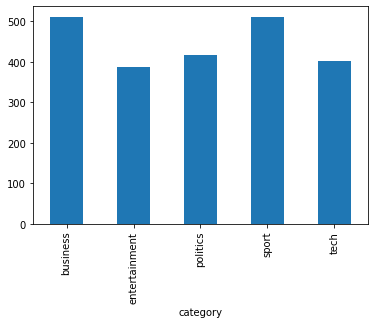

In [82]:
import matplotlib.pyplot as plt
df.groupby('category').file_name.count().plot.bar(ylim=0)

In [83]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df.content).toarray()
labels = df.category_id
features.shape

(2225, 14316)

In [84]:
#correlated words using chi-squared test 
from sklearn.feature_selection import chi2
import numpy as np
N = 3
for category, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(category))
    print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:])))

# 'business':
  . Most correlated unigrams:
       . bank
       . growth
       . shares
  . Most correlated bigrams:
       . analysts said
       . economic growth
       . stock market
# 'entertainment':
  . Most correlated unigrams:
       . awards
       . actor
       . film
  . Most correlated bigrams:
       . film festival
       . los angeles
       . box office
# 'politics':
  . Most correlated unigrams:
       . blair
       . election
       . labour
  . Most correlated bigrams:
       . general election
       . prime minister
       . mr blair
# 'sport':
  . Most correlated unigrams:
       . coach
       . match
       . cup
  . Most correlated bigrams:
       . grand slam
       . australian open
       . champions league
# 'tech':
  . Most correlated unigrams:
       . technology
       . software
       . users
  . Most correlated bigrams:
       . news website
       . anti virus
       . mobile phone


In [85]:
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_score
models = [
  
    LinearSVC(),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

In [86]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC    0.97349
Name: accuracy, dtype: float64

In [87]:
from sklearn.model_selection import train_test_split

model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

Text(0.5, 15.0, 'Predicted')

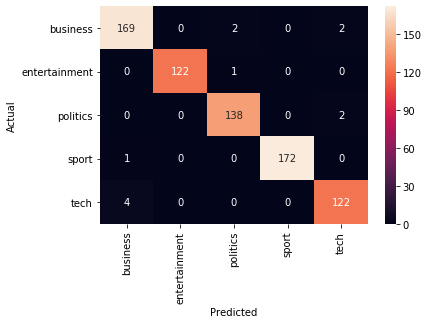

In [88]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.category.values, yticklabels=category_id_df.category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [89]:
model.fit(features, labels)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [90]:
# correlated words using the fitted model

N = 5
for category, category_id in sorted(category_to_id.items()):
    indices = np.argsort(model.coef_[category_id])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
    bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
    print("# '{}':".format(category))
    print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
    print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

# 'business':
  . Top unigrams:
       . bank
       . firm
       . company
       . economic
       . market
  . Top bigrams:
       . chief executive
       . mr glazer
       . stock market
       . analysts said
       . economic growth
# 'entertainment':
  . Top unigrams:
       . film
       . singer
       . music
       . tv
       . star
  . Top bigrams:
       . box office
       . los angeles
       . new york
       . phonographic industry
       . tv shows
# 'politics':
  . Top unigrams:
       . party
       . secretary
       . labour
       . blair
       . government
  . Top bigrams:
       . mr blair
       . mr brown
       . human rights
       . general election
       . spokesman said
# 'sport':
  . Top unigrams:
       . match
       . club
       . cup
       . coach
       . win
  . Top bigrams:
       . year old
       . australian open
       . subs used
       . champions league
       . world number
# 'tech':
  . Top unigrams:
       . computer
       . on

In [91]:
# In how many documents a word present grouped by the document category 
df[df.content.str.lower().str.contains('news website')].category.value_counts()

tech             69
politics          8
entertainment     7
business          1
Name: category, dtype: int64

In [107]:

data_in = []
for file_in in sorted(os.listdir('doc_in')):
    with open('doc_in/'+file_in, 'r') as doc_in:
        content_in = doc_in.read().replace('\n', '')
        data_in.append((file_in , content_in))
df_in = pd.DataFrame(data_in, columns=[ 'file_name','content'])

text_features = tfidf.transform(df_in['content'].tolist())
predictions = model.predict(text_features)
for file_name, predicted in zip(df_in['file_name'], predictions):
    print('{}'.format(file_name)+"  -  {}".format(id_to_category[predicted]) )

002.txt  -  politics
003.txt  -  politics
004.txt  -  politics
005.txt  -  politics
006.txt  -  politics
007.txt  -  politics
008.txt  -  politics
009.txt  -  politics
010.txt  -  politics
011.txt  -  politics
012.txt  -  politics
013.txt  -  politics
014.txt  -  politics
015.txt  -  politics
016.txt  -  politics
017.txt  -  politics
018.txt  -  politics
019.txt  -  entertainment
020.txt  -  entertainment
021.txt  -  entertainment
022.txt  -  entertainment
125.txt  -  politics
126.txt  -  politics
127.txt  -  politics
128.txt  -  politics
129.txt  -  politics
130.txt  -  politics
131.txt  -  politics
132.txt  -  politics
133.txt  -  politics
134.txt  -  politics
135.txt  -  politics
136.txt  -  politics
137.txt  -  politics
138.txt  -  politics
139.txt  -  politics
140.txt  -  politics
141.txt  -  politics
